# **Training ResNet-34 on CIFAR10**

In [1]:
import torch
import torchvision
import os
import numpy as np

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

### **Loading the dataset**

In [2]:
# Normalization & Data Augmentation
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4), 
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(*stats,inplace=True)])
test_tfms = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(*stats)])

In [3]:
batch_size = 128
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tfms)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size*4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### **Implementation of ResNet Model**

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        return self.relu(out + identity)

In [5]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        return self.relu(out + identity)

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, img_channels, classes,  expansion=4):
        super().__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.in_channels = 64

        self.expansion = expansion
        
        # ResNet layers
        self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.4) # added this layer because of overfitting
        self.fc = nn.Linear(512*self.expansion, classes)
    
    def forward(self, x):
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        out = self.layer4(self.layer3(self.layer2(self.layer1(out))))
        out = self.fc(self.flatten(self.avgpool(out)))
        return out

    def make_layer(self, block, num_blocks, out_channels, stride):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*self.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*self.expansion,
                                                          kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels*self.expansion))
        
        layers.append(block(self.in_channels, out_channels, downsample, stride))
        self.in_channels = out_channels*self.expansion

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [7]:
def ResNet18(img_channels=3, classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], img_channels, classes, 1)

def ResNet34(img_channels=3, classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], img_channels, classes, 1)

def ResNet50(img_channels=3, classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], img_channels, classes)

def ResNet101(img_channels=3, classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], img_channels, classes)

def ResNet152(img_channels=3, classes=1000):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], img_channels, classes)

In [8]:
model = ResNet34(3, 10)
for images, labels in train_dl:
    print('Input shape: {}'.format(images.shape))
    out = model(images)
    print('Output shape: {}'.format(out.shape))
    break

Input shape: torch.Size([128, 3, 32, 32])
Output shape: torch.Size([128, 10])


###**Moving data to GPU (if available)**

In [9]:
def get_default_device():
    """Pick GPU if available"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to a device"""
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    def __len__(self):
        """Number of bathces"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(6

### **Defining methods for training the model**

In [13]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_fn(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [14]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    
    return avg_loss, total, avg_metric

In [16]:
def fit(epochs, model, loss_fn, train_dl, valid_dl,
        opt_fn=None, lr=None, metric=None):
    
    train_losses, train_metrics, val_losses, val_metrics = [], [], [], []
    if opt_fn is None:
        opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr, weight_decay=3e-5)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt, metric)

        model.eval()
        train_loss, _, train_metric = evaluate(model, loss_fn, train_dl, metric)
        val_loss, _, val_metric = evaluate(model, loss_fn, valid_dl, metric)

        train_losses.append(train_loss)
        train_metrics.append(train_metric)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        if metric is None:
            print('Epoch [{}/{}, train_loss: {:.4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}, train_loss: {:.4f}, train_{}: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, metric.__name__, 
                          train_metric, val_loss, metric.__name__, val_metric))
    
    return train_losses, train_metrics, val_losses, val_metrics

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

### **Training the model**

In [18]:
num_epochs = 30
opt_fn = torch.optim.Adam
lr = 0.001

In [19]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, test_dl, opt_fn, lr, metric=accuracy)
train_losses, train_metrics, val_losses, val_metrics = history

Epoch [1/30, train_loss: 1.6375, train_accuracy: 0.4448, val_loss: 1.5480, val_accuracy: 0.4693
Epoch [2/30, train_loss: 1.4527, train_accuracy: 0.5503, val_loss: 1.6015, val_accuracy: 0.5611
Epoch [3/30, train_loss: 1.0527, train_accuracy: 0.6312, val_loss: 1.0301, val_accuracy: 0.6435
Epoch [4/30, train_loss: 0.9164, train_accuracy: 0.6835, val_loss: 0.9204, val_accuracy: 0.6923
Epoch [5/30, train_loss: 1.1282, train_accuracy: 0.6306, val_loss: 1.1820, val_accuracy: 0.6373
Epoch [6/30, train_loss: 0.7877, train_accuracy: 0.7285, val_loss: 0.8045, val_accuracy: 0.7269
Epoch [7/30, train_loss: 0.7507, train_accuracy: 0.7370, val_loss: 0.7800, val_accuracy: 0.7344
Epoch [8/30, train_loss: 0.7367, train_accuracy: 0.7403, val_loss: 0.7253, val_accuracy: 0.7476
Epoch [9/30, train_loss: 0.7002, train_accuracy: 0.7562, val_loss: 0.7475, val_accuracy: 0.7482
Epoch [10/30, train_loss: 0.7476, train_accuracy: 0.7502, val_loss: 0.7932, val_accuracy: 0.7418
Epoch [11/30, train_loss: 0.6553, train

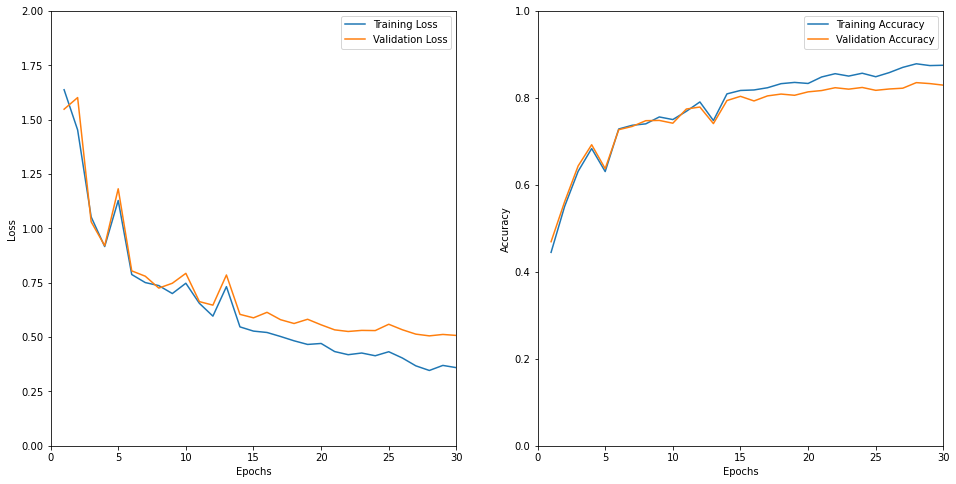

In [20]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Validation Loss')
plt.axis([0, num_epochs, 0, 2])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_metrics, label='Training Accuracy')
plt.plot(np.arange(1, num_epochs+1), val_metrics, label='Validation Accuracy')
plt.axis([0, num_epochs, 0, 1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### **Testing the trained model**

In [21]:
test_loss, _, test_accuracy = evaluate(model, F.cross_entropy, test_dl, accuracy)
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))

Test Loss: 0.5076, Test Accuracy: 0.8293


### **Saving the model**

In [22]:
torch.save(model.state_dict(), 'cifar10-resnet18.pth')    # saves the weights and biases matrices
# to load back, need to define the same structure and then use this file

- Tried Training for few more epochs (allowing model to overfit)
- Didn't help much. But 3 percent gain is still a gain

In [24]:
history_pt = fit(15, model, F.cross_entropy, train_dl, test_dl, opt_fn, 0.0003, metric=accuracy)

Epoch [1/15, train_loss: 0.2529, train_accuracy: 0.9126, val_loss: 0.4557, val_accuracy: 0.8516
Epoch [2/15, train_loss: 0.2388, train_accuracy: 0.9160, val_loss: 0.4628, val_accuracy: 0.8537
Epoch [3/15, train_loss: 0.2328, train_accuracy: 0.9185, val_loss: 0.4634, val_accuracy: 0.8530
Epoch [4/15, train_loss: 0.2234, train_accuracy: 0.9225, val_loss: 0.4576, val_accuracy: 0.8580
Epoch [5/15, train_loss: 0.2134, train_accuracy: 0.9255, val_loss: 0.4637, val_accuracy: 0.8570
Epoch [6/15, train_loss: 0.2067, train_accuracy: 0.9277, val_loss: 0.4692, val_accuracy: 0.8576
Epoch [7/15, train_loss: 0.2043, train_accuracy: 0.9273, val_loss: 0.4778, val_accuracy: 0.8554
Epoch [8/15, train_loss: 0.1952, train_accuracy: 0.9314, val_loss: 0.4695, val_accuracy: 0.8561
Epoch [9/15, train_loss: 0.1909, train_accuracy: 0.9337, val_loss: 0.4723, val_accuracy: 0.8560
Epoch [10/15, train_loss: 0.1841, train_accuracy: 0.9353, val_loss: 0.4715, val_accuracy: 0.8598
Epoch [11/15, train_loss: 0.1823, train